In [58]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [59]:
# ---------- hyperparameters ----------
EPOCHS       = 1000
BATCH_SIZE   = 128
ACTION_SPACE = 3
LATENT_SPACE = 32

Actions: (10002, 3)


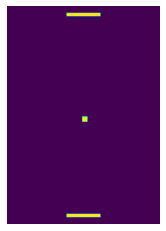

In [3]:
# ---------- training data ----------
actions = np.load('_actions-large.npy')
one_hots = np.zeros((actions.size, 3))

# [1, 0, 0] -> left
# [0, 1, 0] -> Still
# [0, 0, 1] -> Right
for i in range(actions.size):
    one_hots[i][actions[i]+1] = 1

actions = one_hots
print('Actions: ' + str(actions.shape))

screens = np.load('_screens-large.npy')
screens = screens.reshape( (-1, 640, 448, 1) )
screens = screens.astype(np.float32)

plt.axis('off')
plt.imshow(screens[0].reshape(640, 448))
plt.show()

## Create the models

In [60]:
# engine
i = Input( shape=(LATENT_SPACE * 2 + ACTION_SPACE) )

x = Dense( 128 )(i)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)

x = Dense( 256 )(x)
x = LeakyReLU()(x)
x = Dropout(0.1)(x)

x = Dense( 612 )(x)
x = LeakyReLU()(x)

x = Dense( LATENT_SPACE, activation='sigmoid' )(x)

engine = Model(i, x, name='model_3')
engine.compile( loss='mse', optimizer='rmsprop' )
print(engine.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 67)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               8704      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0   

In [61]:
# encoder
encoder = tf.keras.models.load_model('models/encoder.h5')
encoder.trainable = False
print(encoder.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 640, 448, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 107, 75, 16)       4112      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 107, 75, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 13, 16)        16400     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 18, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 32)          8224      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 9, 7, 32)          0     

In [62]:
# renderer
renderer = tf.keras.models.load_model('models/decoder.h5')
renderer.trainable = False
print(renderer.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4480)              147840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4480)              0         
_________________________________________________________________
reshape (Reshape)            (None, 20, 14, 16)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 40, 28, 64)        65600     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 40, 28, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 160, 112, 64)      2622

In [63]:
# model
i = Input( shape=(LATENT_SPACE * 2 + ACTION_SPACE) )
x = engine(i)
x = renderer(x)

model = Model(i, x)

print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 67)]              0         
_________________________________________________________________
model_3 (Model)              (None, 32)                218628    
_________________________________________________________________
model_1 (Model)              (None, 640, 448, 1)       479745    
Total params: 698,373
Trainable params: 218,628
Non-trainable params: 479,745
_________________________________________________________________
None


## Format Training Data
The model's input is the two previous frames plus the action

The two previous frames must first be compressed with the encoder

The traning data is arranged in the following format: [frame_t-2, frame_t-1, action]

In [8]:
# encoded the screens
encoded_frames = encoder.predict(screens)

Xs = []
Ys = []
for i in range(0, screens.shape[0] - 2):
    Xs.append([])
    Xs[i] = encoded_frames[i].tolist() + encoded_frames[i + 1].tolist() + actions[i + 2].tolist()
    
    Ys.append(encoded_frames[i + 2])
    
Xs = np.asarray(Xs)
Ys = np.asarray(Ys)

print(Xs.shape)
print(Ys.shape)

(10000, 67)
(10000, 32)


## Training

In [64]:
# ---------- training loop ----------
history = engine.fit( x=Xs, y=Ys, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.02)
history = history.history

Train on 9800 samples, validate on 200 samples
Epoch 1/1000
9800/9800 [==============================] - 1s 59us/sample - loss: 0.0424 - val_loss: 0.0179
Epoch 2/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0173 - val_loss: 0.0120
Epoch 3/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0132 - val_loss: 0.0102
Epoch 4/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0113 - val_loss: 0.0089
Epoch 5/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0102 - val_loss: 0.0075
Epoch 6/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0095 - val_loss: 0.0072
Epoch 7/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0091 - val_loss: 0.0072
Epoch 8/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0086 - val_loss: 0.0069
Epoch 9/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0083 - val_los

9800/9800 [==============================] - 0s 15us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 77/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 78/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0040 - val_loss: 0.0036
Epoch 79/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0039 - val_loss: 0.0043
Epoch 80/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0039 - val_loss: 0.0043
Epoch 81/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0039 - val_loss: 0.0037
Epoch 82/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 83/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 84/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0038 - val_loss: 0.0039
Epoch 85/1000
9800/9800 [=================

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0037
Epoch 152/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0040
Epoch 153/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0039
Epoch 154/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 155/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0038
Epoch 156/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0037
Epoch 157/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0037
Epoch 158/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0039
Epoch 159/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0033 - val_loss: 0.0039
Epoch 160/1000
9800/9800 [========

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0030 - val_loss: 0.0038
Epoch 227/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0030 - val_loss: 0.0036
Epoch 228/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0031 - val_loss: 0.0035
Epoch 229/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0031 - val_loss: 0.0038
Epoch 230/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0030 - val_loss: 0.0039
Epoch 231/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0030 - val_loss: 0.0036
Epoch 232/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0031 - val_loss: 0.0039
Epoch 233/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0031 - val_loss: 0.0038
Epoch 234/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0030 - val_loss: 0.0035
Epoch 235/1000
9800/9800 [========

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0038
Epoch 302/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0038
Epoch 303/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0042
Epoch 304/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0037
Epoch 305/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0037
Epoch 306/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0028 - val_loss: 0.0037
Epoch 307/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0039
Epoch 308/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0036
Epoch 309/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0029 - val_loss: 0.0037
Epoch 310/1000
9800/9800 [========

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0035
Epoch 377/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0034
Epoch 378/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0035
Epoch 379/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0035
Epoch 380/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0036
Epoch 381/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0035
Epoch 382/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0039
Epoch 383/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0027 - val_loss: 0.0034
Epoch 384/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0027 - val_loss: 0.0036
Epoch 385/1000
9800/9800 [========

9800/9800 [==============================] - 0s 15us/sample - loss: 0.0027 - val_loss: 0.0035
Epoch 452/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0027 - val_loss: 0.0036
Epoch 453/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0026 - val_loss: 0.0034
Epoch 454/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0027 - val_loss: 0.0035
Epoch 455/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0026 - val_loss: 0.0034
Epoch 456/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0027 - val_loss: 0.0040
Epoch 457/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0026 - val_loss: 0.0036
Epoch 458/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0026 - val_loss: 0.0035
Epoch 459/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0026 - val_loss: 0.0035
Epoch 460/1000
9800/9800 [========

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0026 - val_loss: 0.0036
Epoch 527/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0026 - val_loss: 0.0037
Epoch 528/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0026 - val_loss: 0.0034
Epoch 529/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0026 - val_loss: 0.0038
Epoch 530/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0026 - val_loss: 0.0035
Epoch 531/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0026 - val_loss: 0.0036
Epoch 532/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0026 - val_loss: 0.0034
Epoch 533/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0026 - val_loss: 0.0035
Epoch 534/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0026 - val_loss: 0.0036
Epoch 535/1000
9800/9800 [========

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0025 - val_loss: 0.0032
Epoch 602/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0033
Epoch 603/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0034
Epoch 604/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0036
Epoch 605/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0035
Epoch 606/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0035
Epoch 607/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0036
Epoch 608/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0036
Epoch 609/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0032
Epoch 610/1000
9800/9800 [========

9800/9800 [==============================] - 0s 15us/sample - loss: 0.0024 - val_loss: 0.0034
Epoch 677/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0039
Epoch 678/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0035
Epoch 679/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0033
Epoch 680/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0037
Epoch 681/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0036
Epoch 682/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0034
Epoch 683/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0036
Epoch 684/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0025 - val_loss: 0.0036
Epoch 685/1000
9800/9800 [========

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0037
Epoch 752/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0034
Epoch 753/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0039
Epoch 754/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0036
Epoch 755/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0035
Epoch 756/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0035
Epoch 757/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0036
Epoch 758/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0035
Epoch 759/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0032
Epoch 760/1000
9800/9800 [========

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0039
Epoch 827/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0035
Epoch 828/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0034
Epoch 829/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0024 - val_loss: 0.0036
Epoch 830/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0038
Epoch 831/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0036
Epoch 832/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0034
Epoch 833/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0033
Epoch 834/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0032
Epoch 835/1000
9800/9800 [========

9800/9800 [==============================] - 0s 15us/sample - loss: 0.0024 - val_loss: 0.0036
Epoch 902/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0023 - val_loss: 0.0036
Epoch 903/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0023 - val_loss: 0.0033
Epoch 904/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0035
Epoch 905/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0035
Epoch 906/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0038
Epoch 907/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0036
Epoch 908/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0024 - val_loss: 0.0035
Epoch 909/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0024 - val_loss: 0.0034
Epoch 910/1000
9800/9800 [========

9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0034
Epoch 977/1000
9800/9800 [==============================] - 0s 15us/sample - loss: 0.0023 - val_loss: 0.0038
Epoch 978/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0036
Epoch 979/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0034
Epoch 980/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0032
Epoch 981/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0036
Epoch 982/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0039
Epoch 983/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0033
Epoch 984/1000
9800/9800 [==============================] - 0s 16us/sample - loss: 0.0023 - val_loss: 0.0039
Epoch 985/1000
9800/9800 [========

## Error visualization

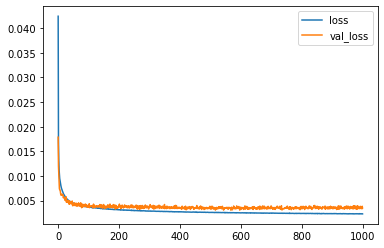

In [65]:
# plot model loss over time
plt.plot(history['loss']        , label='loss')
plt.plot(history['val_loss']    , label='val_loss')

plt.legend(loc=1)
plt.show()

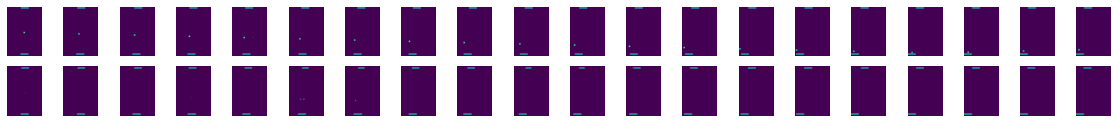

In [66]:
# see how quickly the model diverges
samples = Xs[:80]

predicted_screens = model.predict(samples)
true_screens = screens[2:82]

# render the predicted & actual screens
images = np.concatenate((true_screens[::4], predicted_screens[::4]))

# Create a figure from the predicted and real images
cols, rows = 20, 2
fig=plt.figure(figsize=(20, 2))

for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(images[i-1])

# Save the figure to the images dir
plt.show()

In [67]:
predictions = screens[500:502]

for i in np.asarray(range(2, 202)):
    
    inputs  = encoder.predict(predictions[i-2:i])
    inputs = inputs.reshape(-1)
    inputs = np.concatenate((inputs, actions[i]))
    
    prediction = model.predict(np.reshape(inputs, (1, 67)))
    
    predictions = np.concatenate((predictions, prediction))
    
print(predictions.shape)

(202, 640, 448, 1)


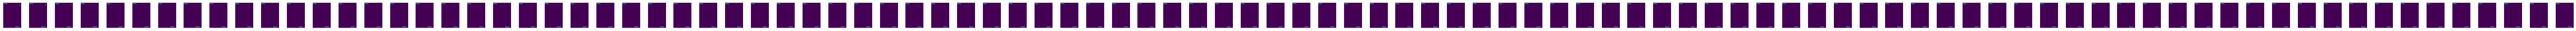

In [68]:
cols, rows = 100, 1
fig=plt.figure(figsize=(100, 1))

for i in range(1, cols*rows +1):
    fig.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(predictions[i-1])

plt.show()